#  交通事故理赔审核预测

* 林昊晗
* 2015300010


## 任务简介

1. 目的：将交通事故现场数据作为训练集，训练得到理赔预测模型，并根据该模型对测试集进行预测。
2. 训练集：csv文件，200000*37， 有200000条样本，每个样本36个特征(36个问题)，每个特征由整数表示（问题的答案）。最后一列为该样本是否获得理赔。
3. 测试集：csv文件，80000*36，同上，除了没有标签。


## 解决途径

1. 整体思路：
<br>这是一个十分显而易见的二分类问题。与之前做过的作业题略有不同的是，本题的状态变量多达36个，所以第一个思路当然是降维，主流方法有PCA等。但是降维可能会造成特征权重分配不合理或者特征丢失，因此我打算采用神经网络模型进行预测。神经网络的好处是可以进行高维度的输入和输出，并且可以在不同层使用不同的激活函数，从而使模型训练得更好。
2. 具体实现：
<br>在这里调用Keras库里的model等神经网络函数，可以方便的定义隐藏层数以及各层的参数。

In [19]:
from keras.models import Model #将各个层组合成全连接神经网络的函数
from keras.layers import Input, Dense #构建各层用到的函数
from keras.utils import np_utils
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

In [20]:
batch_size = 20000 #每次训练用到的数据规模
num_epochs = 40 #训练次数
hidden_size = 50 #隐藏层节点数

num_train = 200000 #训练样本数
spe_len = 36 #每个样本参数数量
num_classes = 2 #二分类

In [21]:
#读取数据集
train_data = np.array(pd.read_csv('train.csv'))
test_data = np.array(pd.read_csv('test.csv'))
X_train = train_data[:,1:-1]
X_train = X_train.astype('float32') #源数据是int类型，这里需要转换成float
y_train = train_data[:,-1]
#由于是二分类问题，输出层有两个节点，所以需要将label处理成两列。
Y_train = np_utils.to_categorical(y_train, num_classes)

X_test = test_data[:,1:]

In [22]:
'''创建输入层，隐藏层1、2，输出层并建立先后顺序关系。
两个隐藏层节点数和激活函数相同。
注意到两个隐藏层和输出层都有bias，可以使预测模型更精确。
输出层激活函数是softmax。'''

inp = Input(shape=(spe_len,)) 
hidden_1 = Dense(hidden_size, activation='relu', use_bias = True)(inp) 
hidden_2 = Dense(hidden_size, activation='relu', use_bias = True)(hidden_1)
out = Dense(num_classes, activation='softmax', use_bias = True)(hidden_2)

In [23]:
#用Model函数将上述各层连接到一起
model = Model(inputs=inp, outputs=out)

'''定义好模型之后需要通过编译来对学习过程进行配置，
我们可以为模型的编译指定各类参数包括：优化器optimizer，损失函数loss，评估指标metrics'''
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

'''采用反向传播算法训练神经网络。训练完成后，history 会保存模型训练后的相关描述'''
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_split=0.1)

Train on 180000 samples, validate on 20000 samples
Epoch 1/40
180000/180000 [==============================] - 1s 4us/step - loss: 0.5162 - acc: 0.8413 - val_loss: 0.4656 - val_acc: 0.8449
Epoch 2/40
180000/180000 [==============================] - 0s 2us/step - loss: 0.4489 - acc: 0.8429 - val_loss: 0.4249 - val_acc: 0.8419
Epoch 3/40
180000/180000 [==============================] - 0s 2us/step - loss: 0.4174 - acc: 0.8462 - val_loss: 0.3971 - val_acc: 0.8594
Epoch 4/40
180000/180000 [==============================] - 0s 2us/step - loss: 0.3903 - acc: 0.8582 - val_loss: 0.3718 - val_acc: 0.8593
Epoch 5/40
180000/180000 [==============================] - 0s 2us/step - loss: 0.3664 - acc: 0.8569 - val_loss: 0.3487 - val_acc: 0.8592
Epoch 6/40
180000/180000 [==============================] - 0s 2us/step - loss: 0.3456 - acc: 0.8564 - val_loss: 0.3302 - val_acc: 0.8580
Epoch 7/40
180000/180000 [==============================] - 0s 2us/step - loss: 0.3267 - acc: 0.8567 - val_loss: 0.3115 -

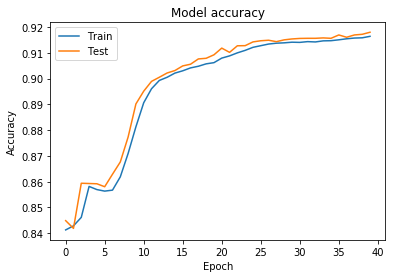

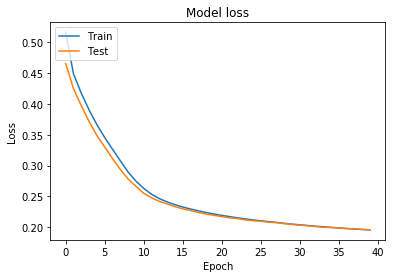

In [32]:
# 绘制训练和测试精度曲线
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练和测试损失函数曲线
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
#对测试集进行预测
test_predict = model.predict_on_batch(X_test)
test_predict = test_predict[:,0]
print(test_predict) 


[0.9998288  0.9948002  0.88191897 ... 0.14280811 0.9995479  0.30411425]


In [34]:
#将预测输出到submit_data.csv中
submitData = pd.read_csv("submit_data.csv")
submitData['Evaluation'] = test_predict
submitData.to_csv("submit_data.csv", index=False)

## 遇到的问题和从中学到的知识

1. 隐藏层数，隐藏层节点数，每次训练用到的样本数量和训练的次数均会影响到训练效果。<br>1). 若隐层节点数太少，模型可能根本不能训练或模型性能很差；若隐层节点数太多，虽然可使模型的误差减小，但一方面使网络训练时间延长，另一方面，训练容易陷入局部极小点而得不到最优点，也是训练时出现“过拟合”的内在原因。训练步长的选择也是类似原理，采用合适的变步长方法可以改善效果。<br>2). batch size越大，训练的越快，精度往往也越好。
2. 最好对输入数据进行归一化，以免引起数据错误。

## 总结
学习任何一门知识最快最有效的办法，就是将其用来解决实际问题。本次报告我采用直接调用Keras库的方法，虽然看起来很省事，但是在选择合适的参数训练的过程中我学到了以前无暇顾及的知识。因为不用关心神经网络的内部算法有没有错误，我可以着眼于输入数据和网络结构对训练效果的影响，这使我对神经网络的原理和特性有了很好地了解。总而言之，感谢老师提供的机会，让我们将课堂上学习的知识真正用到了实处。